In [1]:
## basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## statistics
import statsmodels.formula.api as sm
from scipy.stats import zscore

## system
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

##
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

## internal
import midas

## Define Helper Functions

In [3]:
def scale(df,
          method="standard"):
    if method == "standard":
        scaler = StandardScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df),
                                 index = df.index,
                                 columns = df.columns)
        return df_scaled

    if method == "double_z":
        df_scaled = df.apply(zscore,axis=1).\
            apply(zscore, axis=0)

    else:
        df_scaled = df

    return df_scaled


def umap_wrapper(df,
                 sample_group=['cancer_free'],
                 method="standard",
                 n_neighbors=15,
                 n_components=3,
                 learning_rate=1,
                 min_dist=0.1,
                 metric="euclidean",
                 random_state=42):
    
    df = df.query('sample_group in @sample_group')
    histological_subtype = list(df["histological_subtype"])
    g360_maf = list(np.log(df['g360_max_maf_pct']))
    tvf_maf = list(np.log(df['tvf_max_maf_pct']))
    
    df = df.drop(pdata,axis=1)
    
    df_scaled = scale(df, method=method)
    umap_embedding = umap.UMAP(n_neighbors=n_neighbors,
                              n_components=n_components, 
                              learning_rate=learning_rate,
                              min_dist=min_dist,
                              metric=metric,
                              random_state=random_state)
    
    UMAPS = ["UMAP" + str(i) for i in range(1, n_components+1)]
    res = pd.DataFrame(umap_embedding.fit_transform(df_scaled),
                       columns = UMAPS)
    res = res.assign(histological_subtype = histological_subtype,
                     g360_maf = g360_maf,
                     tvf_maf = tvf_maf)

    return res

def kernel_pca_wrapper(df,
                       scale_method="standard",
                       sample_group=['cancer_free']):
    
    kernels = ['linear','rbf','cosine','poly']
    
    df = df.query('sample_group in @sample_group')
    histological_subtype = list(df["histological_subtype"])
    g360_maf = list(df['g360_max_maf_pct'])
    tvf_maf = list(df['tvf_max_maf_pct'])
    
    df = df.drop(pdata,axis=1)
    
    df_scaled = scale(df,method=scale_method)
    
    fig, axes = plt.subplots(2,2,figsize=(12,10))
    
    axes = axes.flatten()
    
    with plt.style.context('_classic_test_patch'):
        for idx, kernel in enumerate(kernels):
            
            res = KernelPCA(n_components = 3, kernel = kernel).fit_transform(df_scaled)
            
            PCs = ["PC" + str(i) for i in range(1,4)]
            
            res = pd.DataFrame(res, columns=PCs)
            res = res.assign(histological_subtype = histological_subtype,
                     g360_maf = g360_maf,
                     tvf_maf = tvf_maf)
            
            sns.scatterplot(x = "PC2",
                            y = "PC3",
                            #hue = "histological_subtype",
                            data = res,
                            ax = axes[idx])
            
            axes[idx].set_title("+".join(sample_group)+" "+kernel, fontsize=12)
         

## Load Data

In [2]:
with open('/screening/notebooks/zhuang/summer_2024/data/region_ids.pkl', 'rb') as f:
        region_ids = pickle.load(f)

with open('/screening/notebooks/zhuang/summer_2024/data/df_ldt.pkl', 'rb') as f:
        df_ldt = pickle.load(f)

## Query region meta-data to obtain "positive_control" regions
v6_region = "/screening/data/methylation/sandbox_pipeline/assets/mafband_v2023_12_23/msre_regions.tsv"
pos_control = pd.read_csv(v6_region, sep="\t").\
    query('merged_region_type == "HYPER_CONTROL"').\
    loc[:,"region_id"].\
    reset_index(drop=True)
pos_control_in_s3 = [i for i in pos_control if i in region_ids]

print(f"There are {len(pos_control_in_s3)} positive control regions in S3")

## subset data
pdata = ["sample_group","histological_subtype", 'g360_max_maf_pct', 'tvf_max_maf_pct']
df_main = df_ldt.loc[:,["unique_sample_id"]+pdata+region_ids].\
    set_index("unique_sample_id").\
    drop(pos_control_in_s3,axis=1).\
    assign(histological_subtype = lambda df: np.where(df['histological_subtype'].isnull(), "unknown", df['histological_subtype']))

There are 41 positive control regions in S3


In [79]:
df_main.histological_subtype.unique()

array(['adenocarcinoma', 'unknown', 'squamous_cell_carcinoma',
       'carcinoma', 'sarcoma', 'carcinoid', 'colo adenocarcinoma'],
      dtype=object)

## Kernel PCA

### `cancer_free` + standard scaler

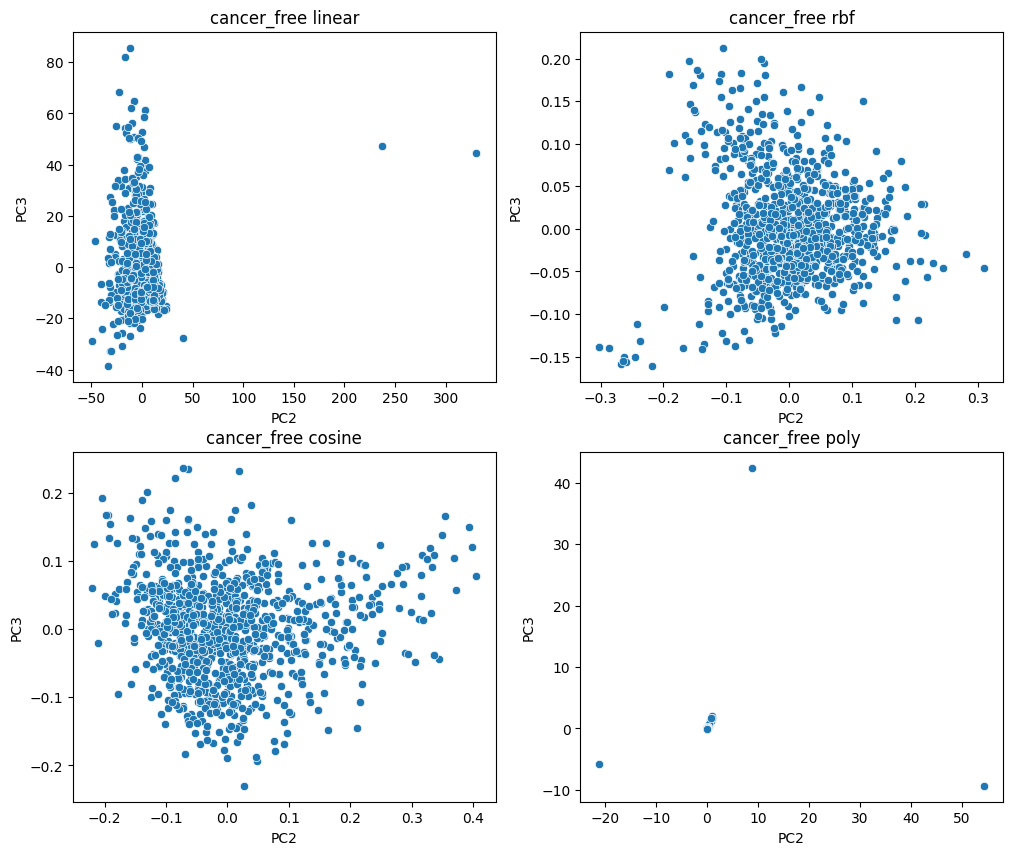

In [4]:
kernel_pca_wrapper(df_main,
                   scale_method="standard",
                   sample_group=['cancer_free'])

### `cancer_free` + double-z

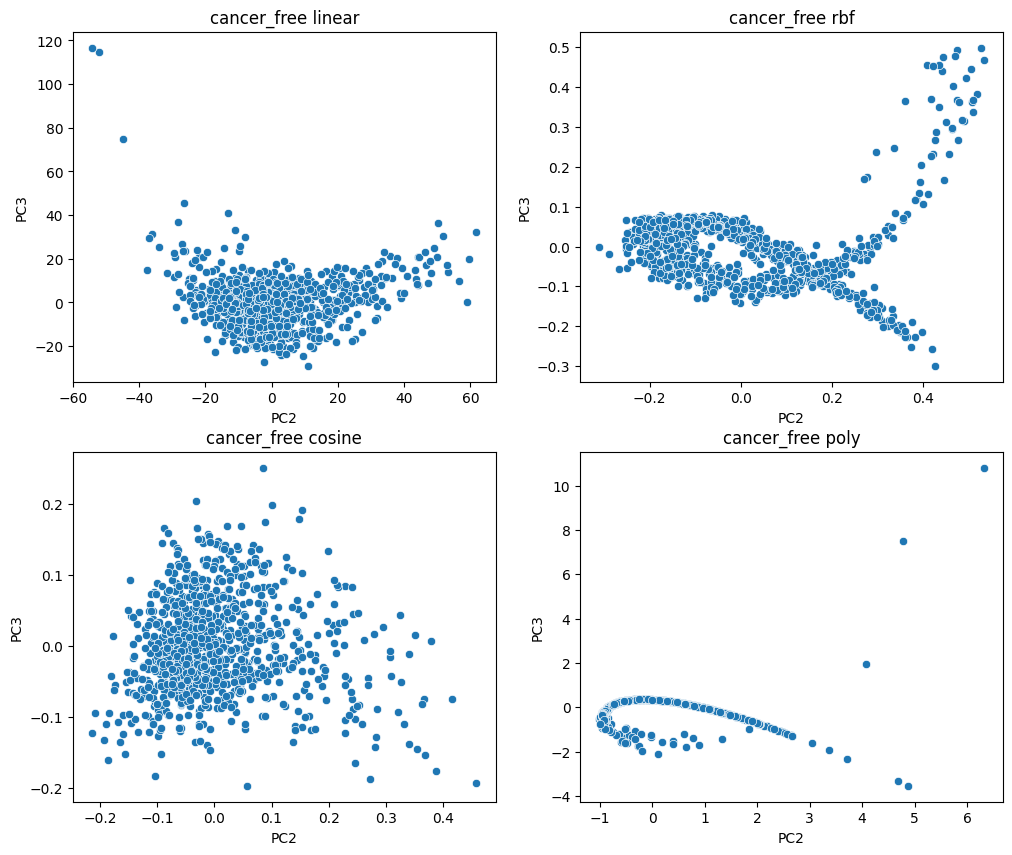

In [5]:
kernel_pca_wrapper(df_main,
                   scale_method="double_z",
                   sample_group=['cancer_free'])

### `lung` + standard scaler

(996, 27301)


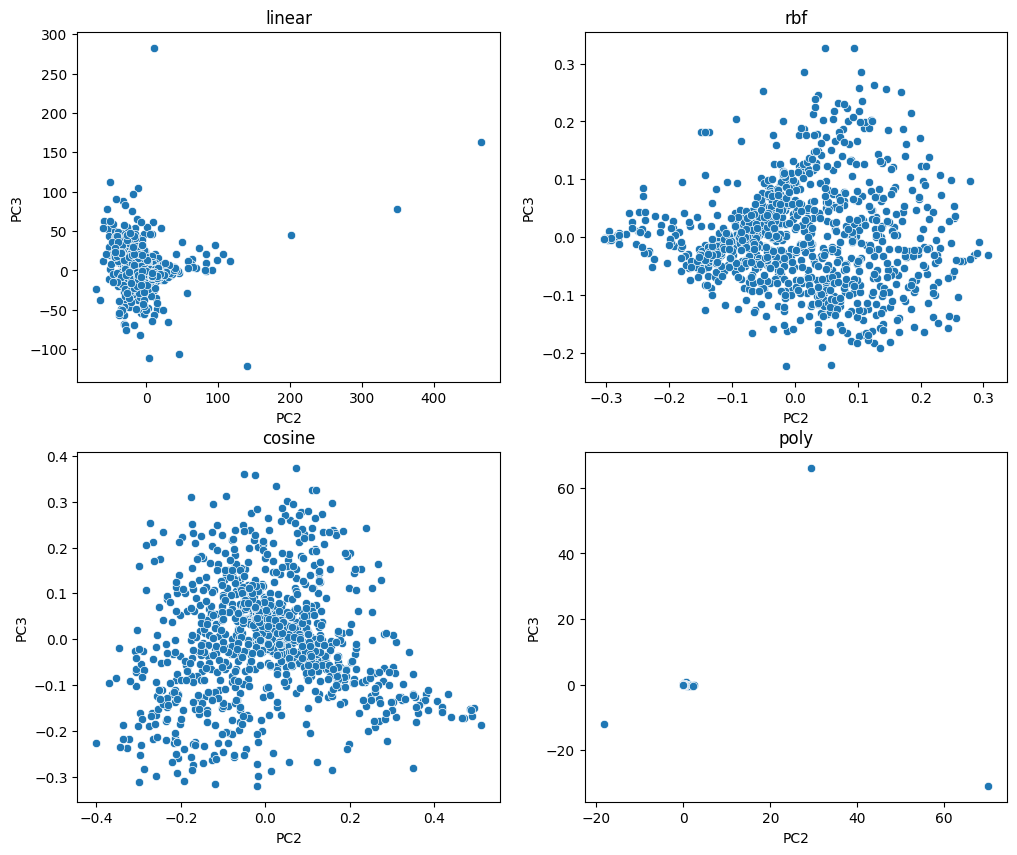

In [7]:
kernel_pca_wrapper(df_main,
                   sample_group=['lung'],
                   scale_method='standard')

### `lung` + double-z

(996, 27301)


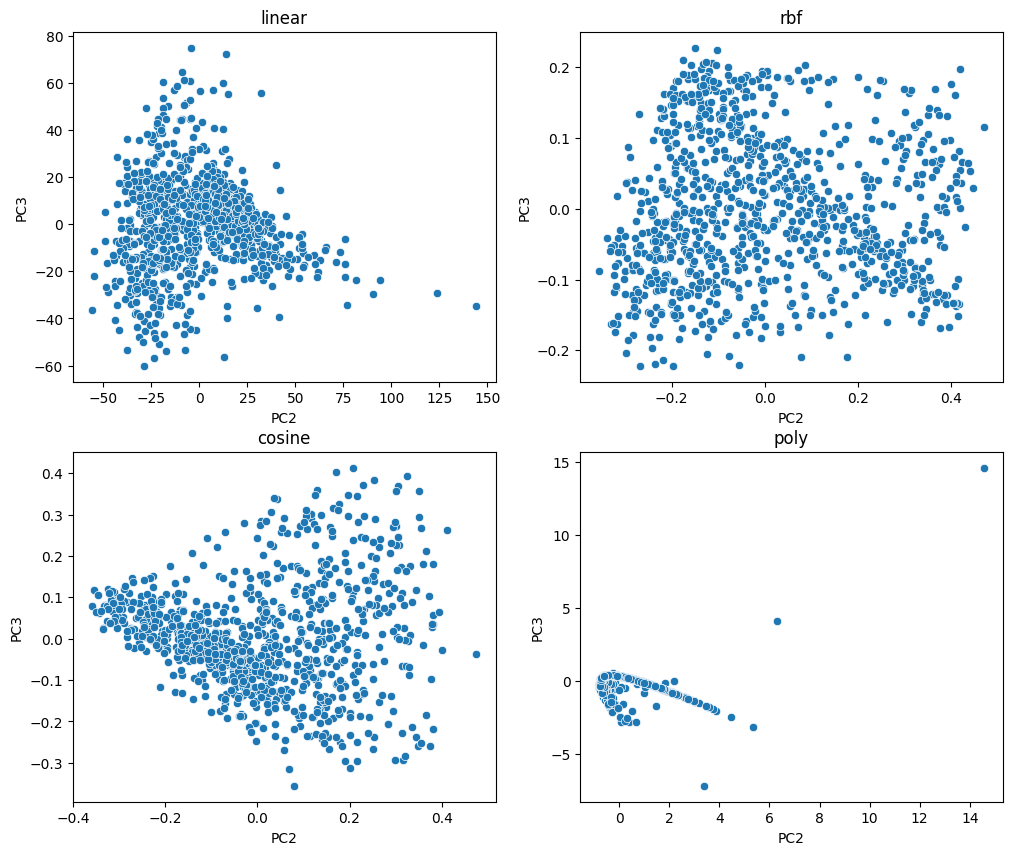

In [8]:
kernel_pca_wrapper(df_main,
                   sample_group=['lung'],
                   scale_method='double_z')

### `crc` + standard

(982, 27301)


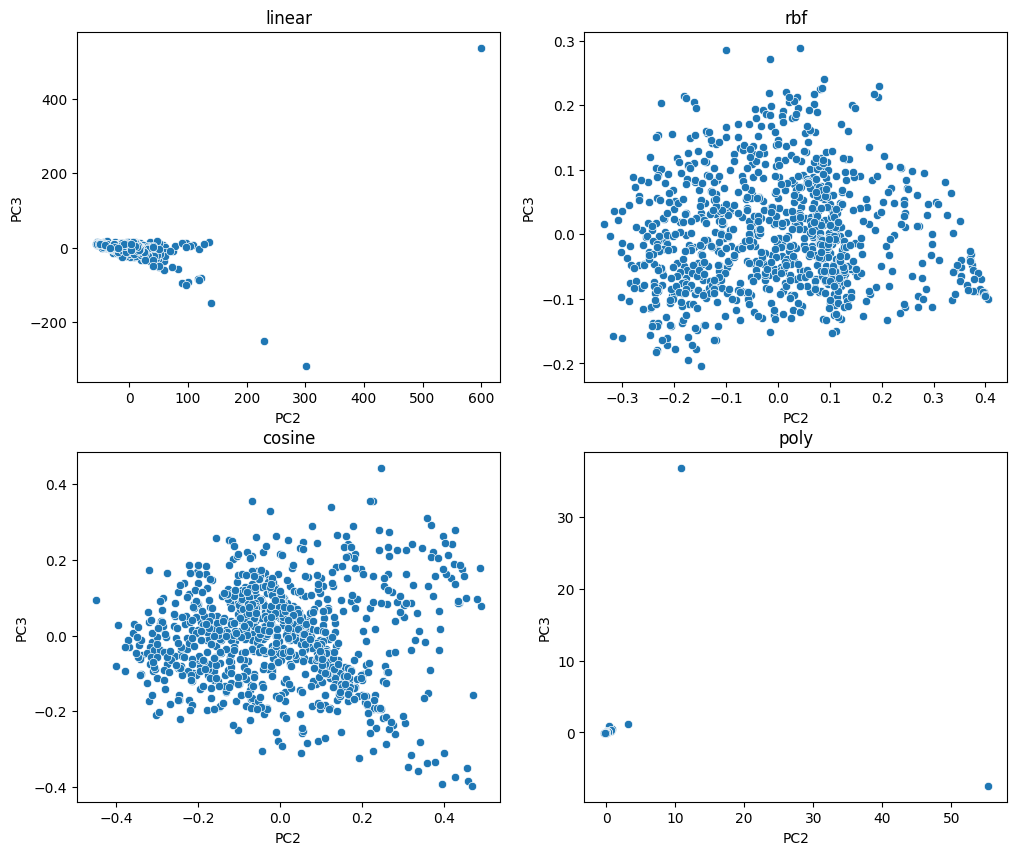

In [9]:
kernel_pca_wrapper(df_main,
                   sample_group=['crc'],
                   scale_method='standard')

### `crc` + double_z

(982, 27301)


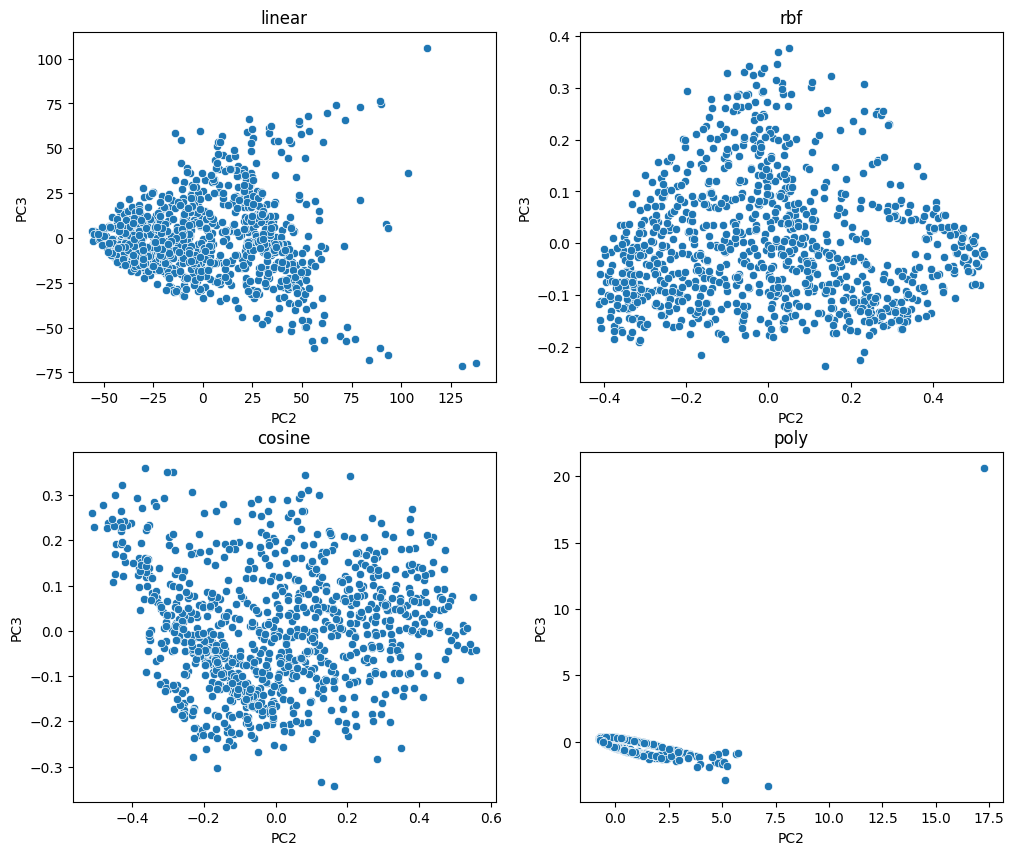

In [10]:
kernel_pca_wrapper(df_main,
                   sample_group=['crc'],
                   scale_method='double_z')

### `breast` + standard

(998, 27301)


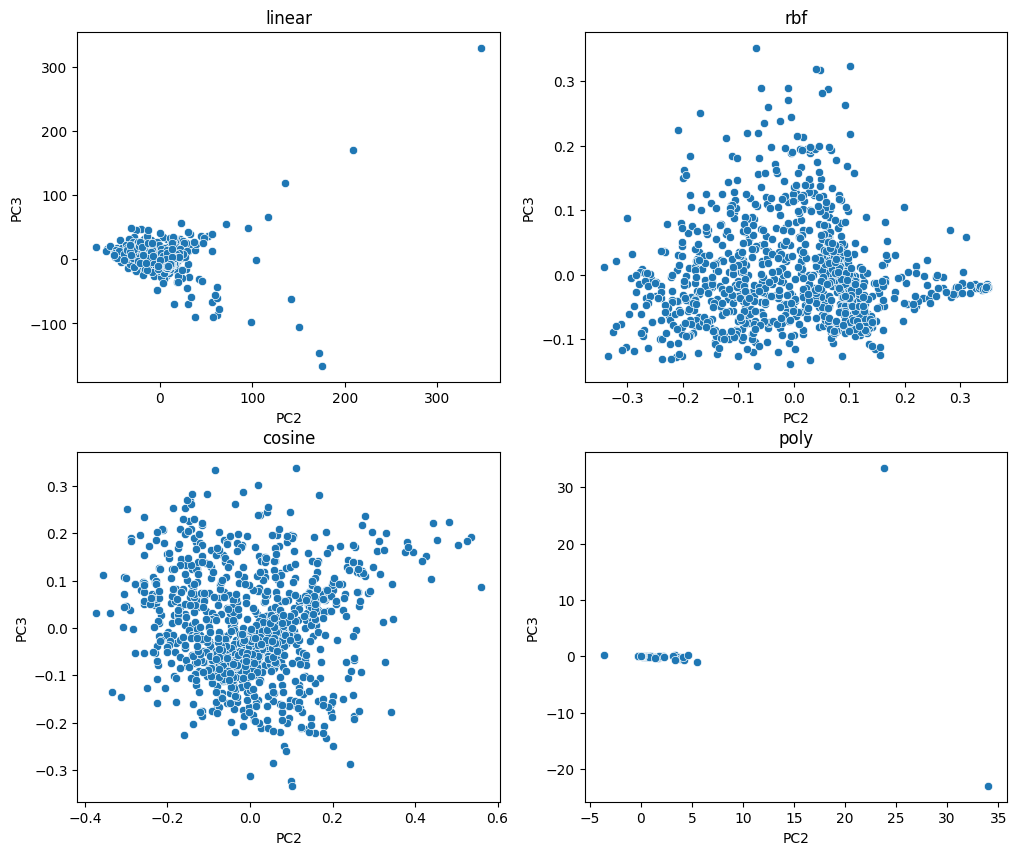

In [11]:
kernel_pca_wrapper(df_main,
                   sample_group=['breast'],
                   scale_method='standard')

### `breast` + double_z

(998, 27301)


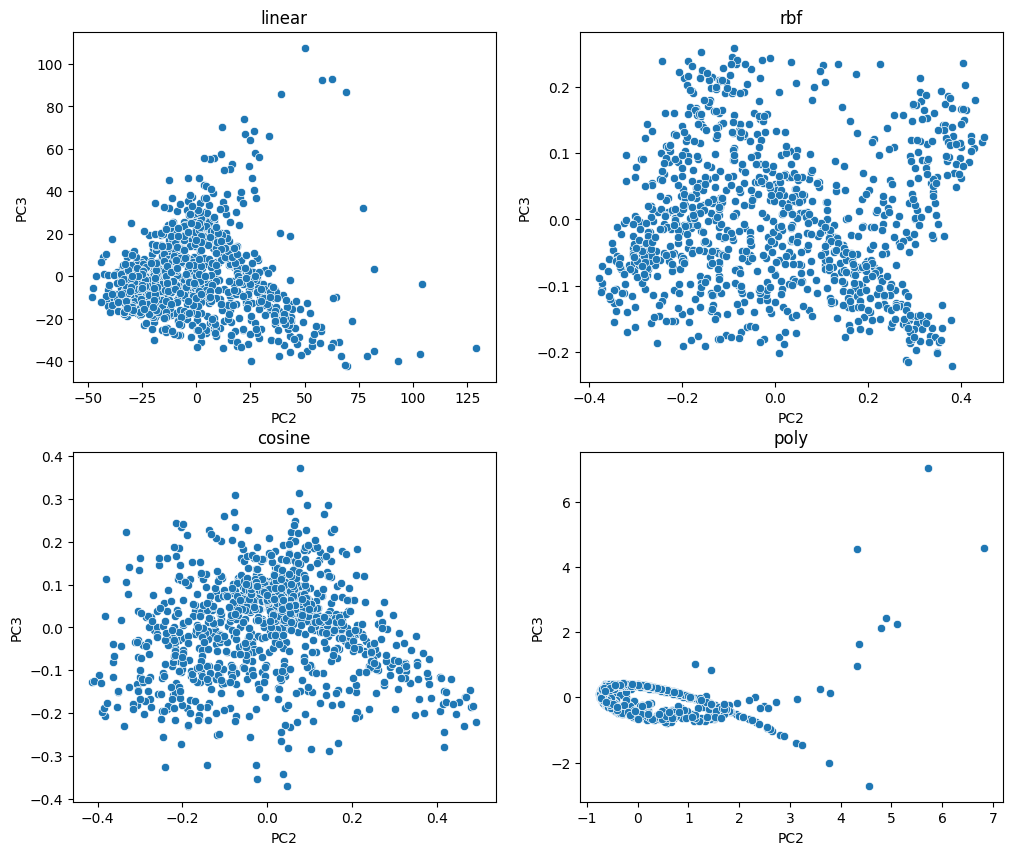

In [12]:
kernel_pca_wrapper(df_main,
                   sample_group=['breast'],
                   scale_method='double_z')

### `cancer_free` + `lung` + standard

(1991, 27301)


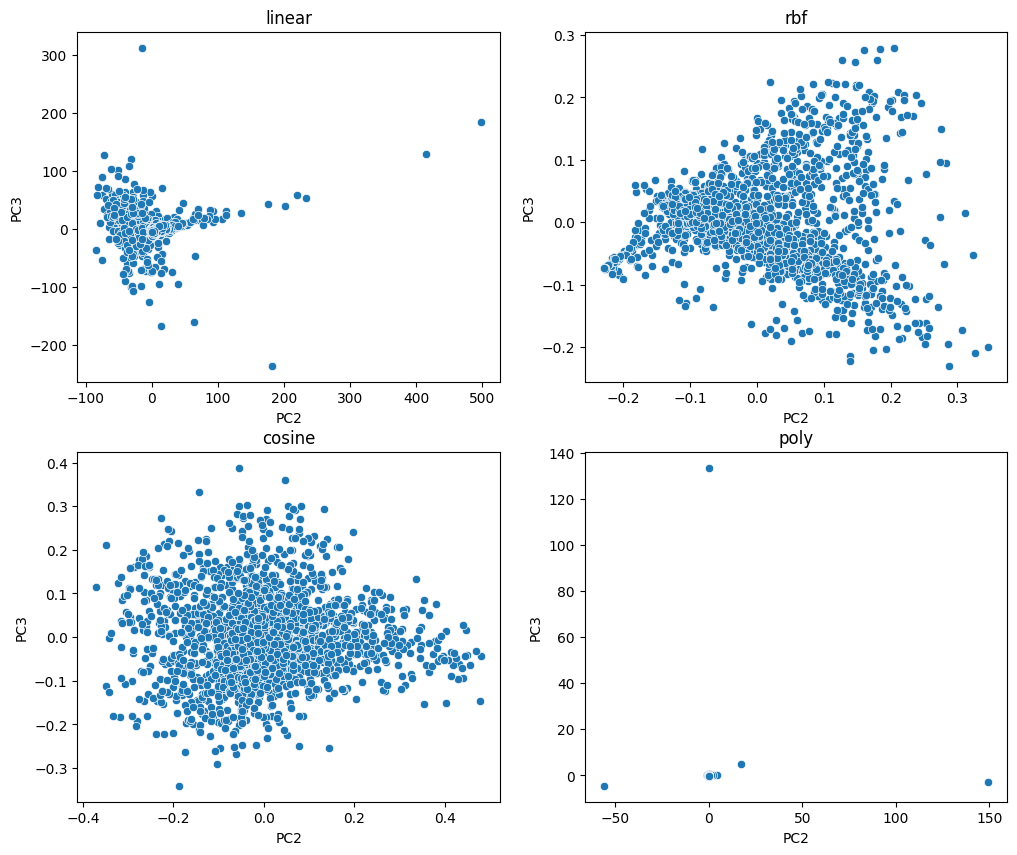

In [13]:
kernel_pca_wrapper(df_main,
                   sample_group=['cancer_free','lung'],
                   scale_method='standard')

### `cancer_free` + `lung` + double_z

(1991, 27301)


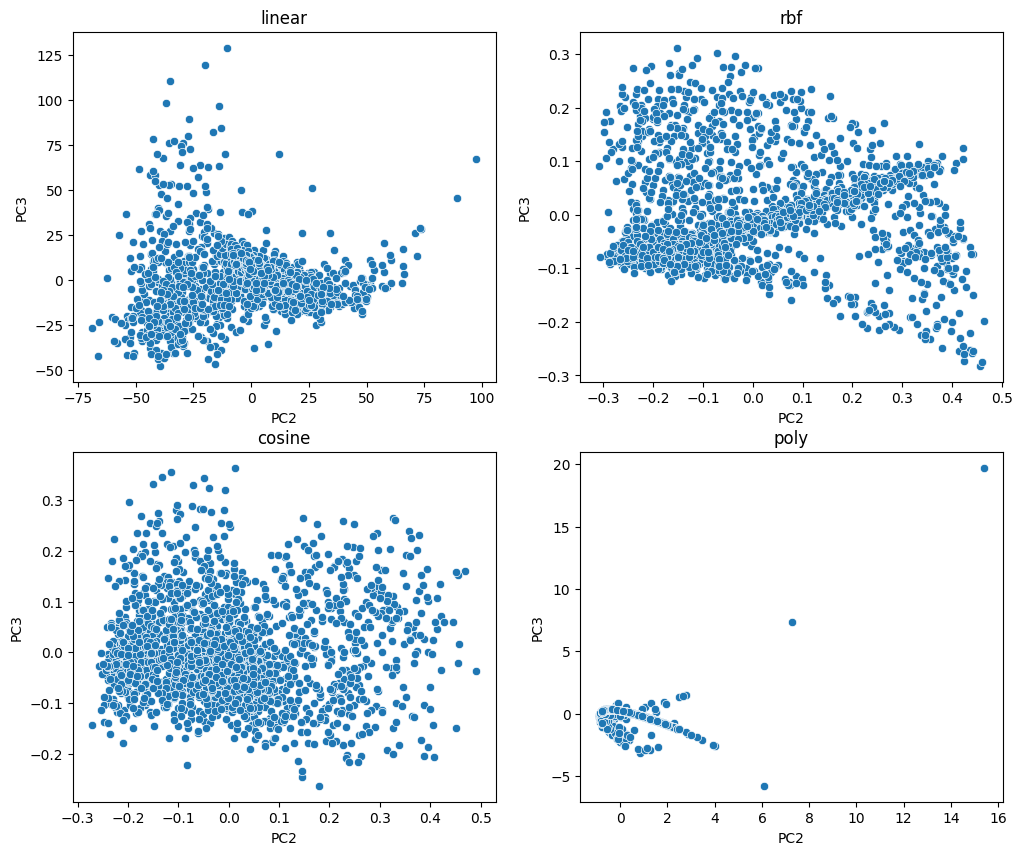

In [14]:
kernel_pca_wrapper(df_main,
                   sample_group=['cancer_free','lung'],
                   scale_method='double_z')

### `cancer_free` + `crc` + standard

(1977, 27301)


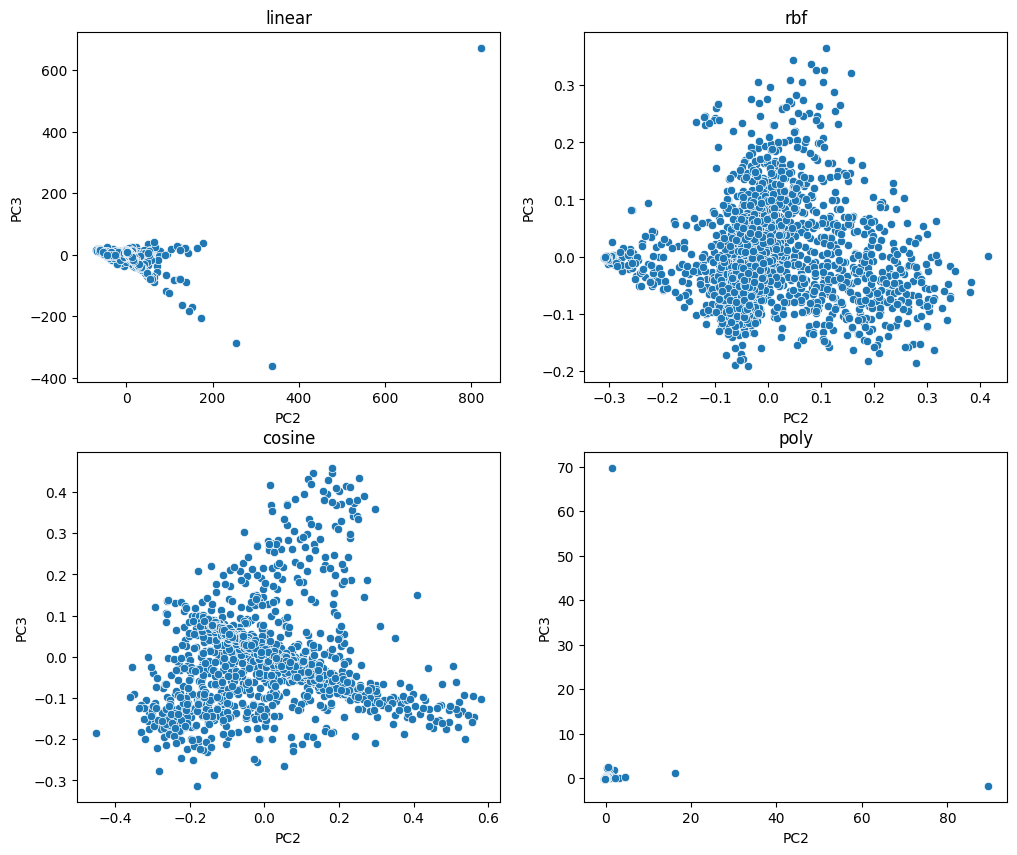

In [15]:
kernel_pca_wrapper(df_main,
                   sample_group=['cancer_free','crc'],
                   scale_method='standard')

### `cancer_free` + `crc` + double_z

(1977, 27301)


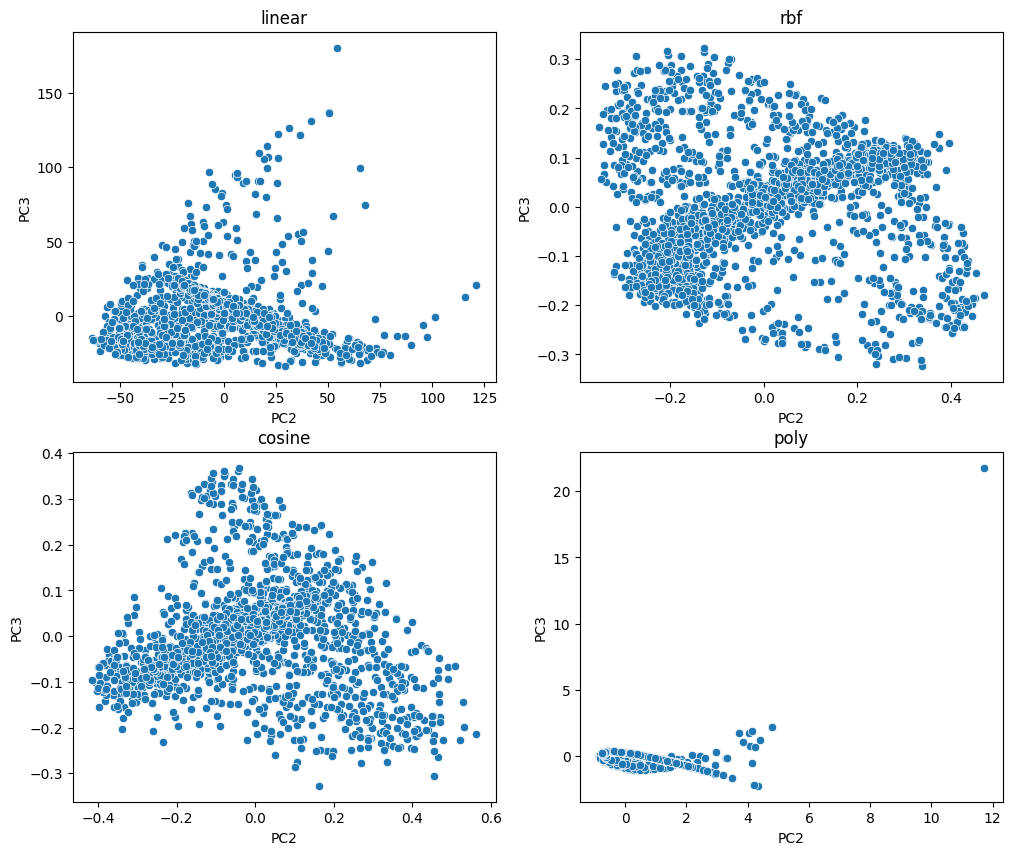

In [16]:
kernel_pca_wrapper(df_main,
                   sample_group=['cancer_free','crc'],
                   scale_method='double_z')

### `lung` + `crc` + standard

(1978, 27301)


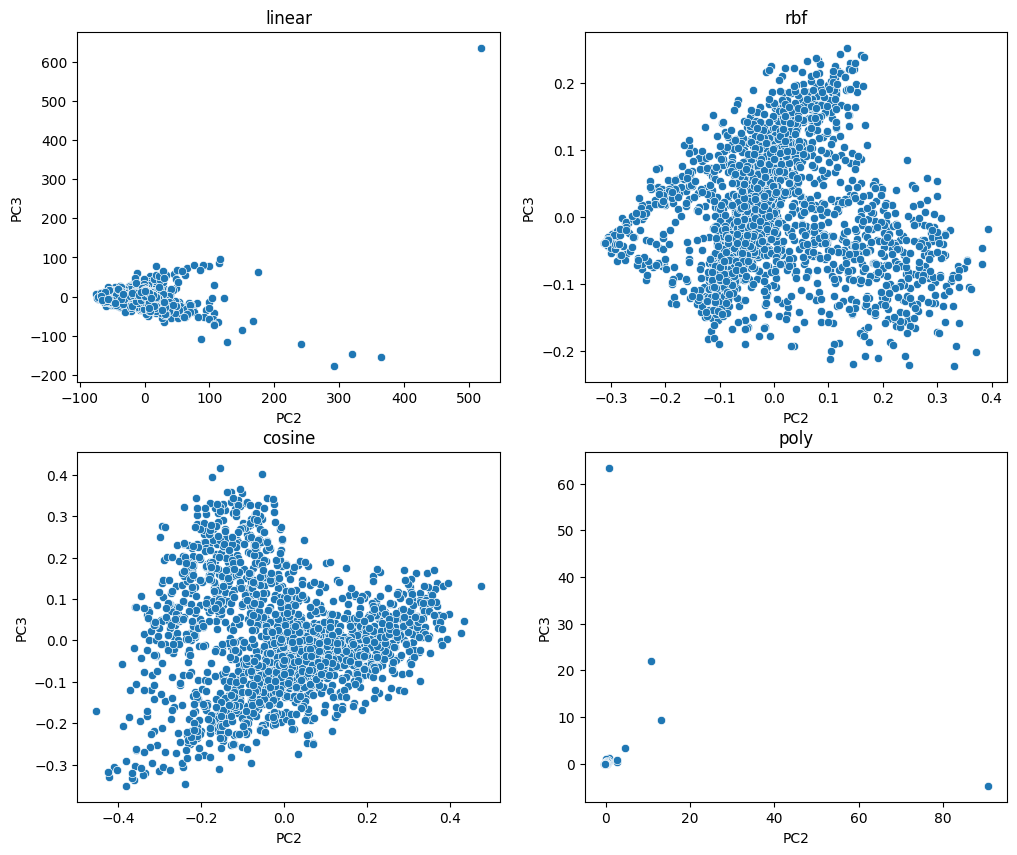

In [17]:
kernel_pca_wrapper(df_main,
                   sample_group=['lung','crc'],
                   scale_method='standard')

### `lung` + `crc` + double_z

(1978, 27301)


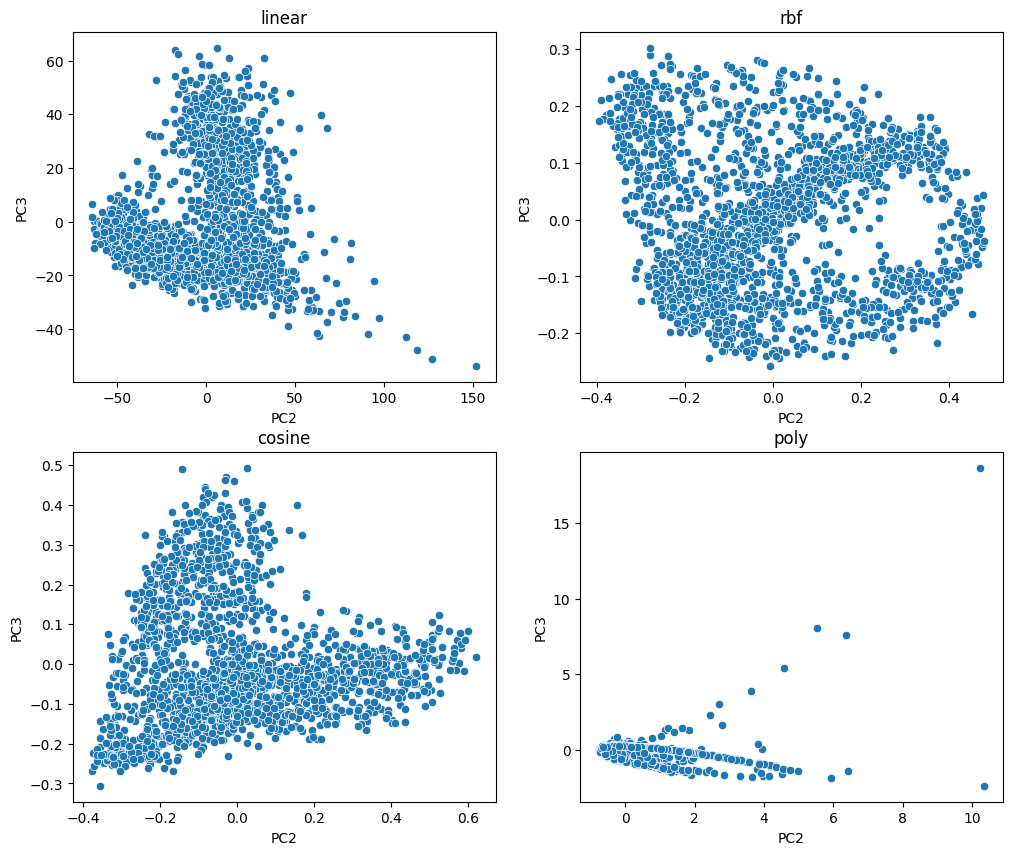

In [18]:
kernel_pca_wrapper(df_main,
                   sample_group=['lung','crc'],
                   scale_method='double_z')

## Linear PCA Explained Variance Ratio

### Standard-scaling

(995, 27301)
(996, 27301)
(982, 27301)
(998, 27301)


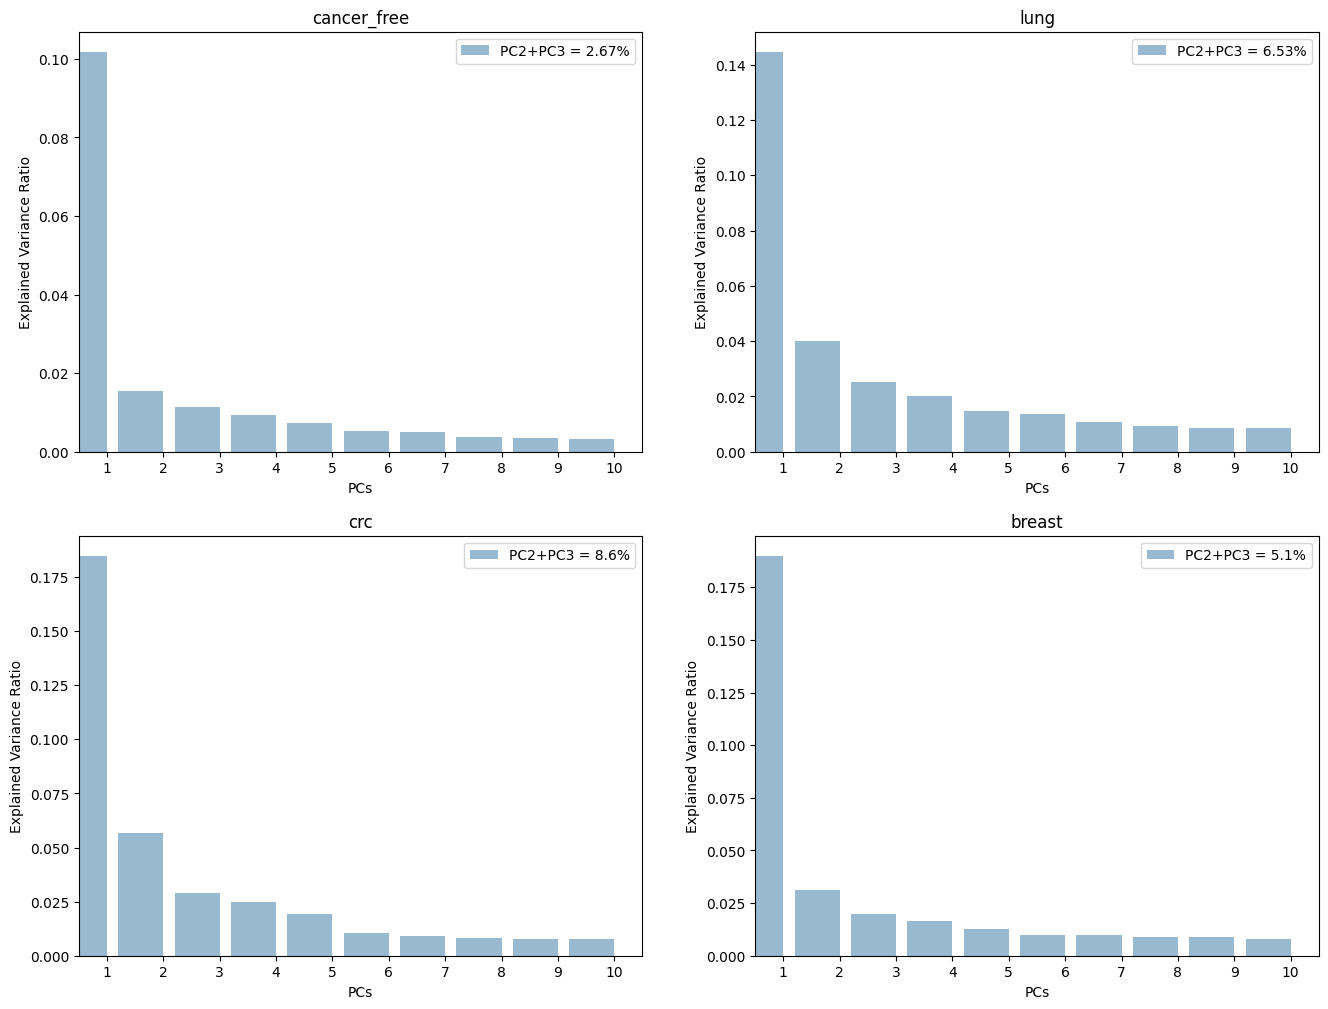

In [11]:
#sample_groups = [['cancer_free'],['lung'],['crc'],['breast'],['cancer_free','lung'],['cancer_free','crc']]
sample_groups = [['cancer_free'],['lung'],['crc'],['breast']]
scale_method = "standard"

fig, axes = plt.subplots(2,2,figsize=(16,12))
axes = axes.flatten()

with plt.style.context('_classic_test_patch'):
    for idx, sample_group in enumerate(sample_groups):
        df = df_main.query('sample_group in @sample_group').\
            drop(pdata,axis=1)
        print(df.shape)
        
        df_scaled = scale(df,method=scale_method)
        pca = PCA(n_components=10)
        df_pca = pca.fit_transform(df_scaled)
        var_ratio = pca.explained_variance_ratio_
        cum_sum = np.cumsum(var_ratio)
    
        sns.barplot(x = list(range(1, len(var_ratio)+1)),
                    y = var_ratio,
                    alpha = 0.5,
                    align = "center",
                    label = f"PC2+PC3 = {np.round((cum_sum[2]-cum_sum[0])*100,2)}%",
                    ax = axes[idx])
    
        axes[idx].set_title("+".join(sample_group), fontsize=12)
        axes[idx].set_xlabel("PCs", fontsize=10)
        axes[idx].set_ylabel("Explained Variance Ratio", fontsize=10)
        axes[idx].legend()

### Double-z

(995, 27301)
(996, 27301)
(982, 27301)
(998, 27301)


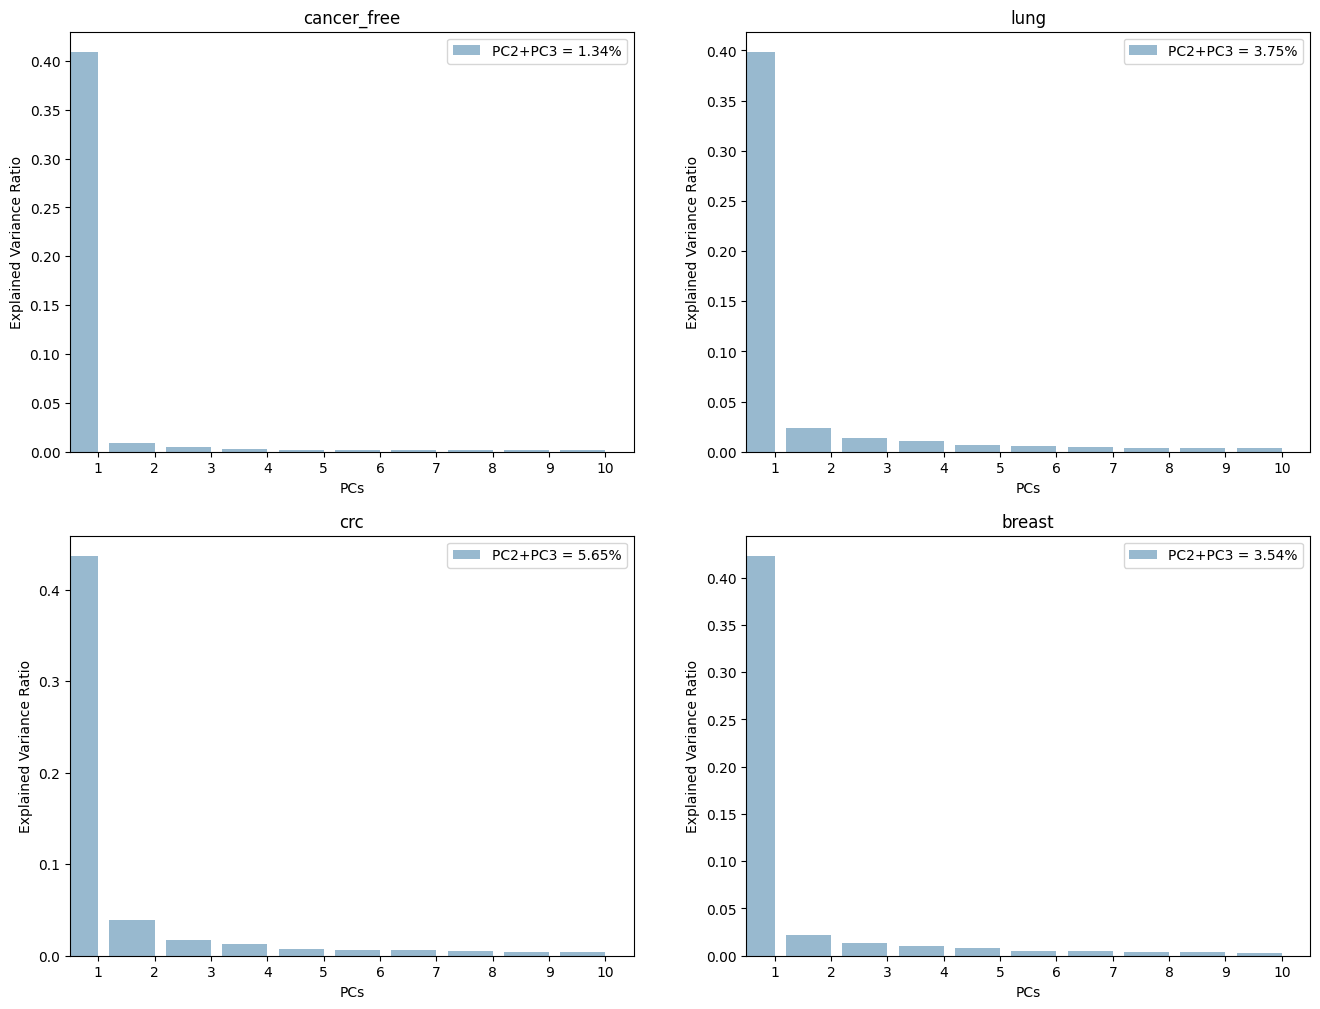

In [13]:
#sample_groups = [['cancer_free'],['lung'],['crc'],['breast'],['cancer_free','lung'],['cancer_free','crc']]
sample_groups = [['cancer_free'],['lung'],['crc'],['breast']]
scale_method = "double_z"

fig, axes = plt.subplots(2,2,figsize=(16,12))
axes = axes.flatten()

with plt.style.context('_classic_test_patch'):
    for idx, sample_group in enumerate(sample_groups):
        df = df_main.query('sample_group in @sample_group').\
            drop(pdata,axis=1)
        print(df.shape)
        
        df_scaled = scale(df,method=scale_method)
        pca = PCA(n_components=10)
        df_pca = pca.fit_transform(df_scaled)
        var_ratio = pca.explained_variance_ratio_
        cum_sum = np.cumsum(var_ratio)
    
        sns.barplot(x = list(range(1, len(var_ratio)+1)),
                    y = var_ratio,
                    alpha = 0.5,
                    align = "center",
                    label = f"PC2+PC3 = {np.round((cum_sum[2]-cum_sum[0])*100,2)}%",
                    ax = axes[idx])
    
        axes[idx].set_title("+".join(sample_group), fontsize=12)
        axes[idx].set_xlabel("PCs", fontsize=10)
        axes[idx].set_ylabel("Explained Variance Ratio", fontsize=10)
        axes[idx].legend()

## UMAP

### Standard-scaling

(995, 6)
(996, 6)
(982, 6)
(998, 6)


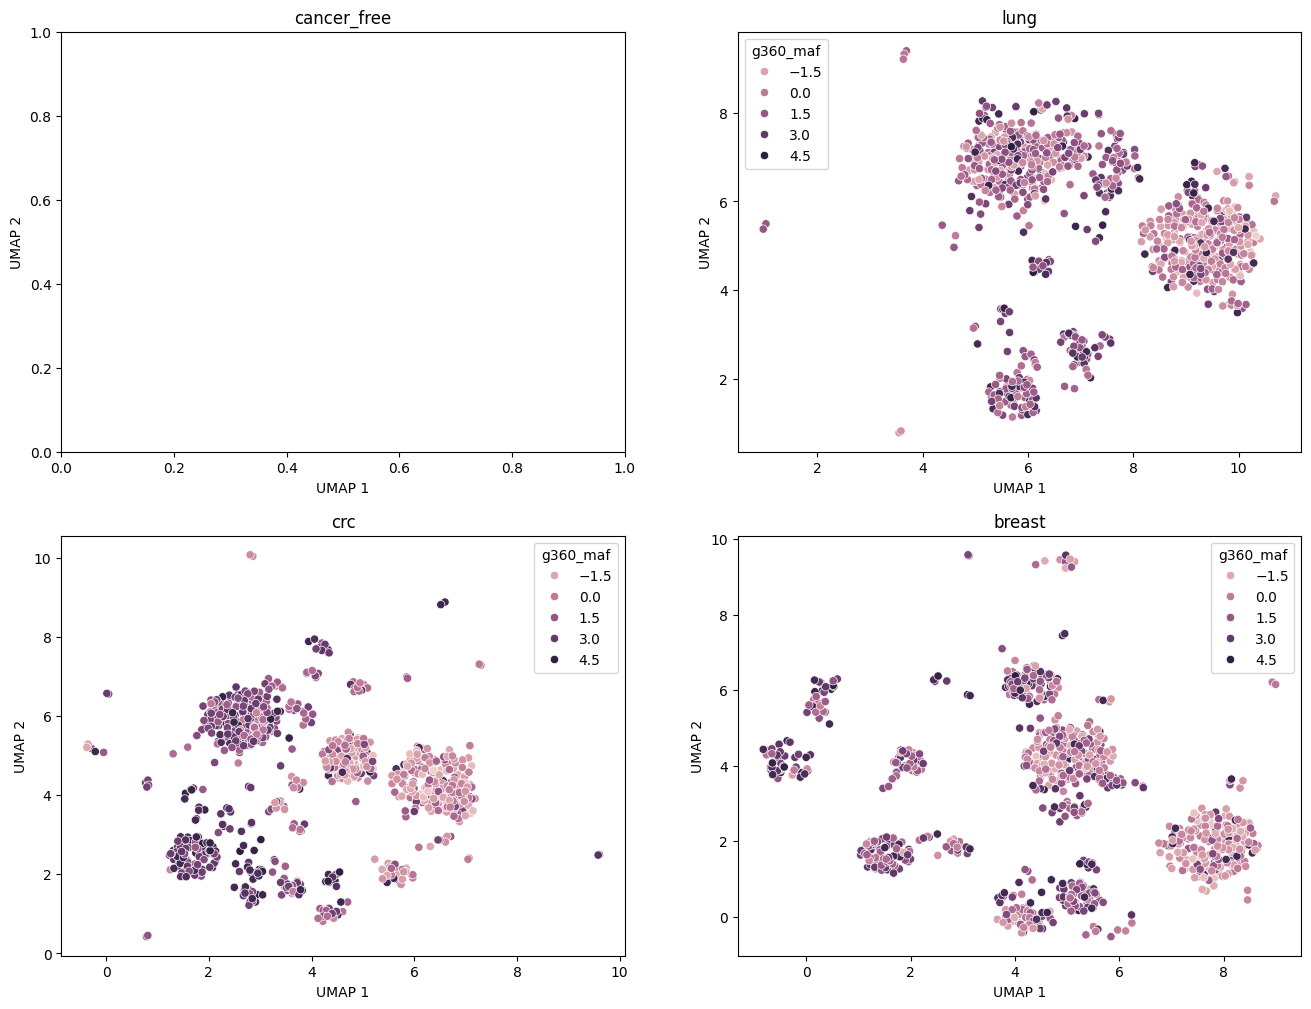

In [16]:
#sample_groups = [['cancer_free'],['lung'],['crc'],['breast'],['cancer_free','lung'],['cancer_free','crc']]
sample_groups = [['cancer_free'],['lung'],['crc'],['breast']]
scale_method = "standard"

fig, axes = plt.subplots(2,2,figsize=(16,12))
axes = axes.flatten()

with plt.style.context('_classic_test_patch'):
    for idx, sample_group in enumerate(sample_groups):
        
        res = umap_wrapper(df_main,
                           method = scale_method,
                           sample_group=sample_group,
                           n_neighbors=2,
                           min_dist=0.5,
                           learning_rate=0.01)

        print(res.shape)
        
        sns.scatterplot(x = "UMAP1",
                        y = "UMAP2",
                        hue = "g360_maf",
                        data = res,
                        ax = axes[idx])
        
        axes[idx].set_title("+".join(sample_group), fontsize=12)
        axes[idx].set_xlabel("UMAP 1", fontsize=10)
        axes[idx].set_ylabel("UMAP 2", fontsize=10)

### Double-z

(995, 6)
(996, 6)
(982, 6)
(998, 6)


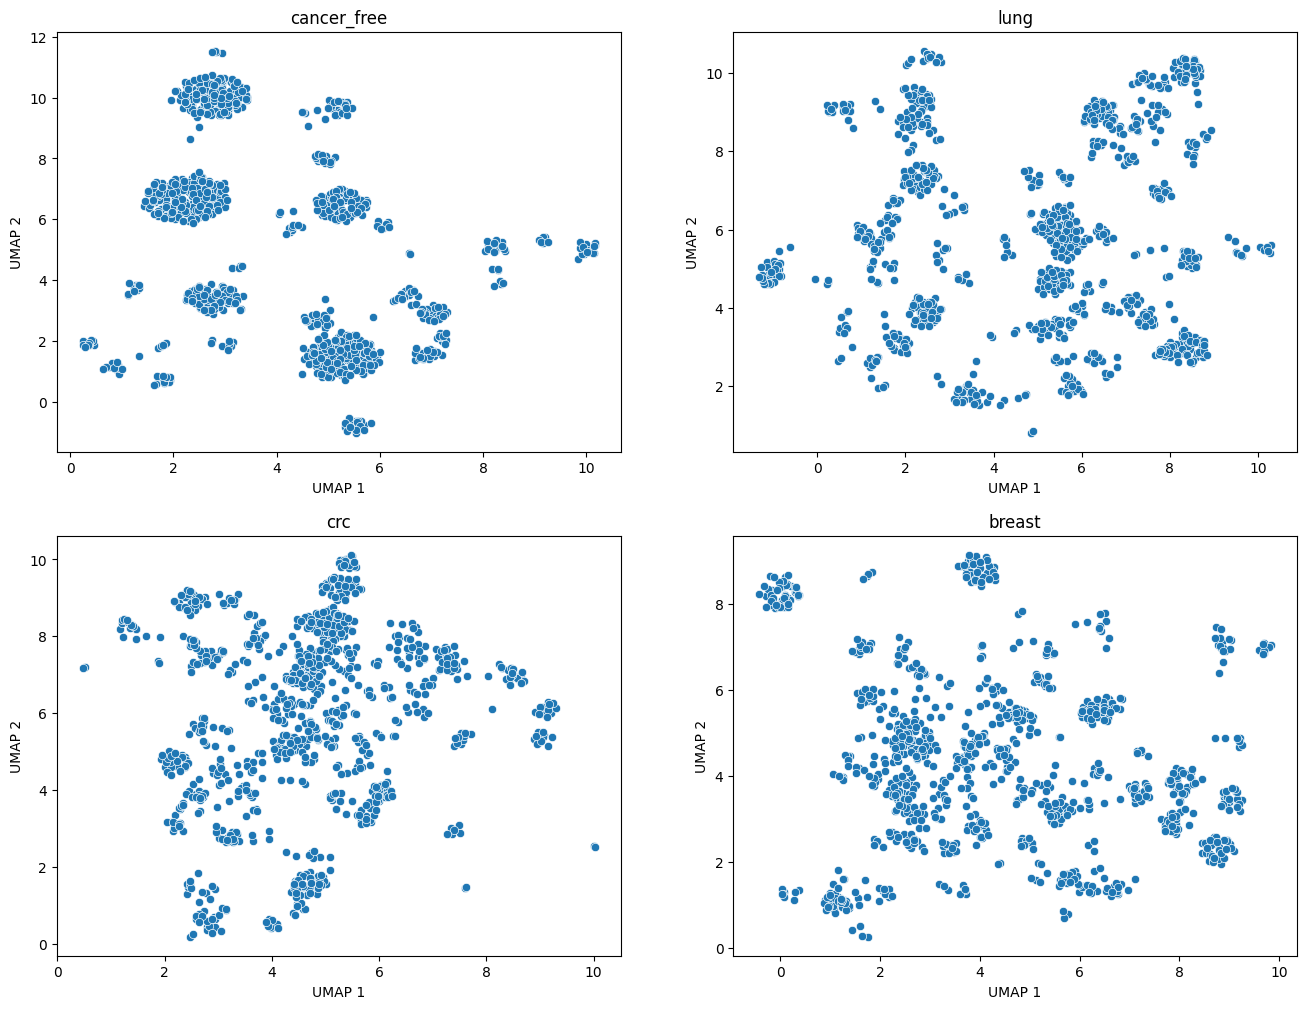

In [18]:
#sample_groups = [['cancer_free'],['lung'],['crc'],['breast'],['cancer_free','lung'],['cancer_free','crc']]
sample_groups = [['cancer_free'],['lung'],['crc'],['breast']]
scale_method = "double_z"

fig, axes = plt.subplots(2,2,figsize=(16,12))
axes = axes.flatten()

with plt.style.context('_classic_test_patch'):
    for idx, sample_group in enumerate(sample_groups):
        
        res = umap_wrapper(df_main,
                           sample_group=sample_group,
                           method = scale_method,
                           n_neighbors=2,
                           min_dist=0.5,
                           learning_rate=0.01)

        print(res.shape)
        
        sns.scatterplot(x = "UMAP1",
                        y = "UMAP2",
                        #hue = "g360_maf",
                        data = res,
                        ax = axes[idx])
        
        axes[idx].set_title("+".join(sample_group), fontsize=12)
        axes[idx].set_xlabel("UMAP 1", fontsize=10)
        axes[idx].set_ylabel("UMAP 2", fontsize=10)